<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать 
 их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 
   Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
# 1. Imports
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# 2. Functions. Bagging
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample



In [126]:
# 3. Single Dec Tree
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch
        
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction   
    
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

def entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:
            impurity -= p * np.log2(p)
        
    return impurity

def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def quality2(left_labels, right_labels, current_entropy): # case for entropy
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels, use_entropy):
    min_leaf = 1
    current_gini = gini(labels)
    current_entropy = entropy(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            if use_entropy:
                current_quality = quality2(true_labels, false_labels, current_entropy)
            else:
                current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def build_tree(data, labels, use_entropy):

    quality, t, index = find_best_split(data, labels, use_entropy)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels, use_entropy)
    false_branch = build_tree(false_data, false_labels, use_entropy)
    return Node(index, t, true_branch, false_branch)

In [123]:
# 4. Random Forest

def random_forest(data, labels, n_trees, use_entropy=False):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, use_entropy=use_entropy))
        
    return forest

def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    predictions_per_object = list(zip(*predictions))
    
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [115]:
# 5. Predict and validation

def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

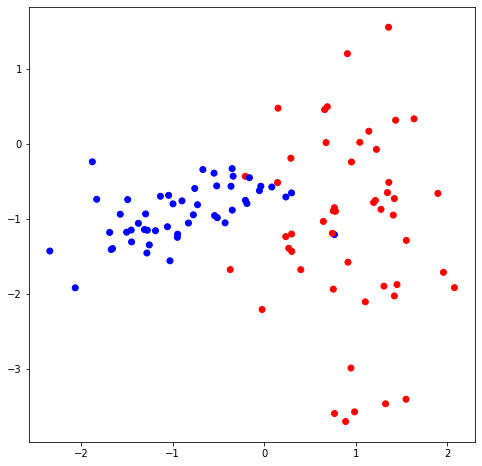

In [116]:
# 6. Генерация данных

classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)


colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [134]:
# 7. Разделение данных
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [139]:
# 8. Run and visualize functions

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def run_fit_score(train_data, train_labels, test_data, test_labels, 
                  n_trees,  use_entropy=False, show_metrics=True, show_plot=False):
    
    rf = random_forest(data=train_data, labels=train_labels, n_trees=n_trees, use_entropy=use_entropy)
    train_answers = tree_vote(forest=rf, data=train_data)
    test_answers = tree_vote(forest=rf, data=test_data)
    train_accuracy = accuracy_metric(actual=train_labels, predicted=train_answers)
    test_accuracy = accuracy_metric(actual=test_labels, predicted=test_answers)
    
    if show_metrics:
        print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
        print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {test_accuracy:.3f}')
    
    if show_plot:
        xx, yy = get_meshgrid(data=train_data)
        idx = 1
        for tree in rf:
            plt.figure(figsize = (4, 4))
            mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree)).reshape(xx.shape)
            plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
            plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
            idx += 1
            
    return rf, train_accuracy, test_accuracy

Точность случайного леса из 3 деревьев на обучающей выборке: 98.571
Точность случайного леса из 3 деревьев на обучающей выборке: 83.333


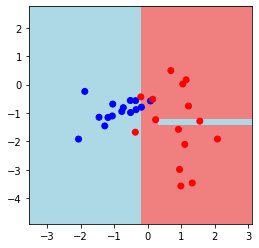

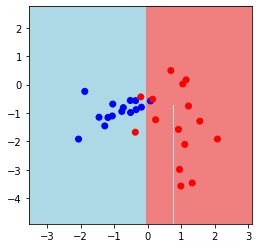

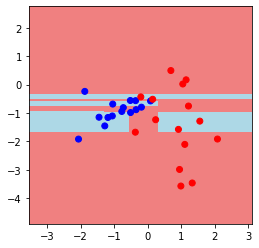

In [140]:
# 9. Testing single random forest
rf1 = run_fit_score(train_data, train_labels, test_data, test_labels, n_trees=3, show_metrics=True, show_plot=True)

In [155]:
# 10. Running different n-trees


tree_range = [1, 3, 10, 50]
train_acc, test_acc = [], []

for n in tree_range:
    np.random.seed(42)
    rf, train_accuracy, test_accuracy = run_fit_score(train_data, train_labels, test_data, test_labels, n_trees=n, 
                                                      show_metrics=False, show_plot=False)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

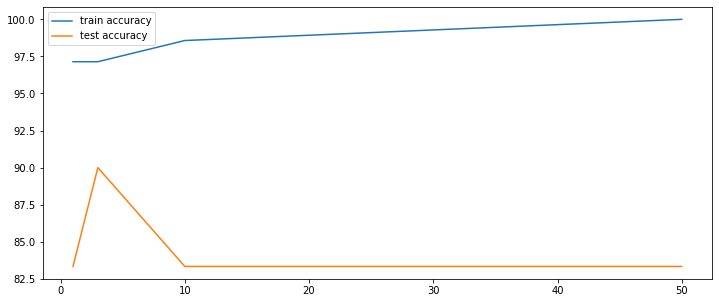

In [156]:
plt.figure(figsize=(12,5))
plt.plot(tree_range, train_acc, label='train accuracy')
plt.plot(tree_range, test_acc, label='test accuracy')
plt.legend()
plt.show()

Выводы:
- увеличение числа деревьев не всегда приводит к улучшению метрик при большом количестве деревьев
- в данном случае оптимальное число деревьев - 3

 3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [163]:
# формула Шэннона - в Single Dec Tree функциях
print('Gini parameter')
print('-'*50)
rf2 = run_fit_score(train_data, train_labels, test_data, test_labels, n_trees=3, 
                    use_entropy=False,  show_metrics=True, show_plot=False)
print('-'*50)
print('Entropy parameter')
print('-'*50)
rf3 = run_fit_score(train_data, train_labels, test_data, test_labels, n_trees=3, 
                    use_entropy=True,  show_metrics=True, show_plot=False)

Gini parameter
--------------------------------------------------
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на обучающей выборке: 86.667
--------------------------------------------------
Entropy parameter
--------------------------------------------------
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на обучающей выборке: 83.333
